Making of the neural network, training of the neural network, and testing on various model happens here.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.functional import relu

U-net model

In [2]:
from unet_xxp import UNet

Load the alphabets.

In [3]:
import pickle

alpha = {}
dirty_alpha = {}
with open('../Input_Representation/data/other/alphabet.pkl', 'rb') as f:
    alpha = pickle.load(f)
with open('../Input_Representation/data/other/dirty_alphabet.pkl', 'rb') as f:
    dirty_alpha = pickle.load(f)


Making the dataset and making the Dataloader.

In [4]:
import torchvision

class transpose:
    def __init__(self):
        pass

    def __call__(self, sample):
        return sample.T

class flatten:
    def __init__(self):
        pass

    def __call__(self, sample):
        new_sample = sample.flatten()

transform = torchvision.transforms.Compose([transpose(), flatten(), transpose()])

In [5]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    '''
    Contains the dataset.
    '''
    # def __init__(self, alpha, dirty_alpha, transform=None):
    #     '''
    #     Initialize the dataset.
    #     '''
    #     self.data = []
    #     self.labels = []
    #     for key, value in alpha.items():
    #         if key in dirty_alpha:
    #             for i, stroke in enumerate(dirty_alpha[key]):
    #                 self.labels.append(torch.Tensor(value[0]))
    #                 self.data.append(torch.Tensor(stroke))
    #         else:
    #             continue
    #     self.data = np.array(self.data, dtype=torch.Tensor)
    #     self.labels = np.array(self.labels, dtype=torch.Tensor)

    def __init__(self, alpha, dirty_alpha, transform=None):
        '''
        Initialize the dataset.
        '''
        self.data = []
        self.labels = []
        self.n = 1
        for key, value in alpha.items():
            if key in dirty_alpha:
                for i, stroke in enumerate(dirty_alpha[key]):
                    self.labels.append(torch.Tensor(value[0]))
                    self.data.append(torch.Tensor(stroke))
            else:
                continue

    def __getitem__(self, index):
        x = self.data[index // self.n]
        y = self.labels[index // self.n]
        return x, y

    def __len__(self):
        return len(self.data)*self.n

dataset = MyDataset(alpha, dirty_alpha)
# dataset_test = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
dataloader = DataLoader(dataset=dataset, batch_size=362, shuffle=True, num_workers=1)

torch.Size([3, 256]) torch.Size([3, 256])


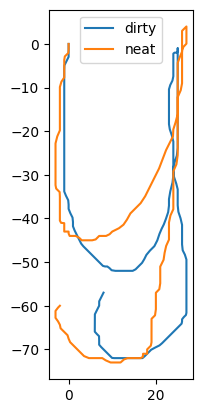

In [6]:
dataiter = iter(dataloader)
data = next(dataiter)
features, labels = data
print(features[0].shape, labels[0].shape)
# print(features[0].numpy())

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(features[0].numpy()[0], features[0].numpy()[1]*-1, label="dirty")
ax.plot(labels[0].numpy()[0], labels[0].numpy()[1]*-1, label="neat")
ax.set_aspect('equal', adjustable='box')
ax.legend()

plt.show()

In [7]:
def interpolate(stroke, length):
        '''
        This funtion takes a normal input stroke and returns a stroke 
        with the a contant length of "len" using linear interpolation.
        '''
        x, y, p = stroke
        size = stroke.shape[1]
        interp_x = np.interp(np.linspace(0, size, length, endpoint=True), np.arange(size), x)
        interp_y = np.interp(np.linspace(0, size, length, endpoint=True), np.arange(size), y)
        interp_p = np.interp(np.linspace(0, size, length, endpoint=True), np.arange(size), p)
        return np.stack([interp_x, interp_y, interp_p], axis=0)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

num_epochs = 1000
learning_rate = 0.0001

model = UNet(3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(dataloader)
losses = []
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)

        # forward pass
        # outputs = torch.Tensor([interpolate(stroke, 252) for stroke in model(features).detach().numpy()])
        outputs = model(features)
        loss = criterion(outputs.requires_grad_(), labels)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'model_xxp.ckpt')


cuda
Epoch [1/1000], Step [1/1], Loss: 299.4072
Epoch [2/1000], Step [1/1], Loss: 297.2550
Epoch [3/1000], Step [1/1], Loss: 295.1325
Epoch [4/1000], Step [1/1], Loss: 292.9952
Epoch [5/1000], Step [1/1], Loss: 290.8206
Epoch [6/1000], Step [1/1], Loss: 288.6236
Epoch [7/1000], Step [1/1], Loss: 286.4460
Epoch [8/1000], Step [1/1], Loss: 284.2079
Epoch [9/1000], Step [1/1], Loss: 281.7626
Epoch [10/1000], Step [1/1], Loss: 278.9725
Epoch [11/1000], Step [1/1], Loss: 275.6364
Epoch [12/1000], Step [1/1], Loss: 271.3964
Epoch [13/1000], Step [1/1], Loss: 265.4025
Epoch [14/1000], Step [1/1], Loss: 255.3618
Epoch [15/1000], Step [1/1], Loss: 236.2942
Epoch [16/1000], Step [1/1], Loss: 201.0986
Epoch [17/1000], Step [1/1], Loss: 182.9807
Epoch [18/1000], Step [1/1], Loss: 182.7412
Epoch [19/1000], Step [1/1], Loss: 169.1080
Epoch [20/1000], Step [1/1], Loss: 174.7037
Epoch [21/1000], Step [1/1], Loss: 173.6978
Epoch [22/1000], Step [1/1], Loss: 165.4574
Epoch [23/1000], Step [1/1], Loss: 1

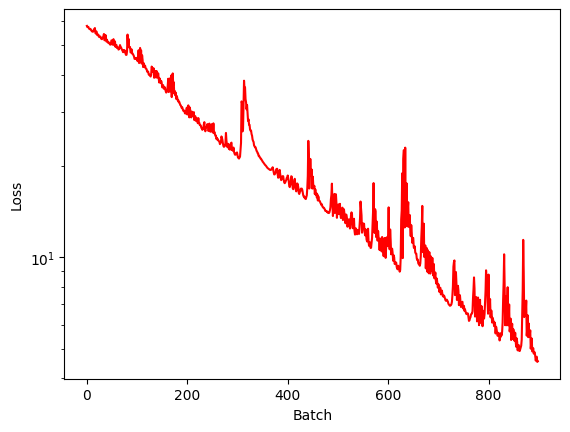

In [9]:
with open("./data/losses/loss_xxp.pkl", "wb") as f:
            pickle.dump(losses, f)

# fig = plt.figure()
plt.plot(losses[100:-1], color='red')
plt.yscale('log')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.savefig('figs/loss_xxp.png')
plt.show()

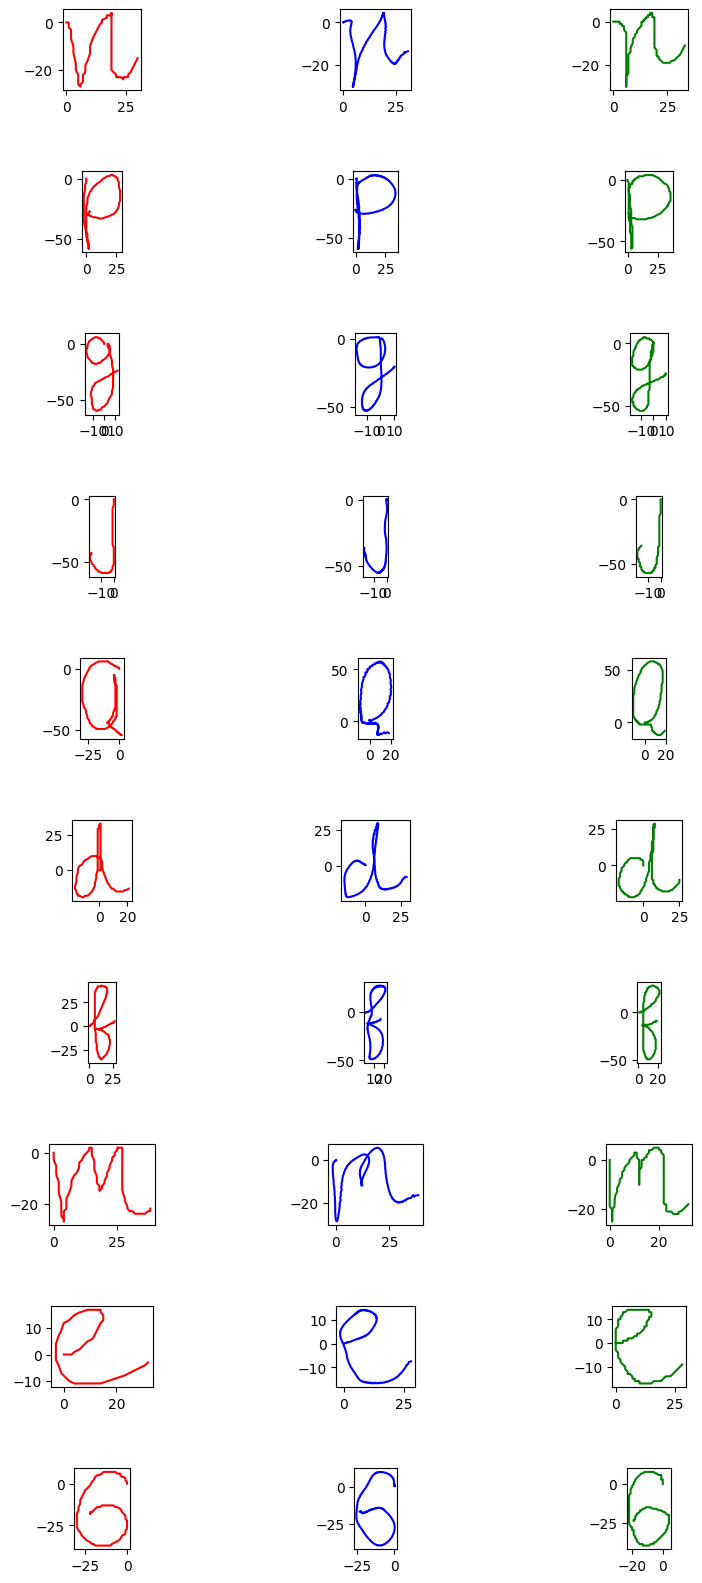

In [10]:
n = 10
plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=1)
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=1)
dataiter = iter(dataloader)
model = model.to("cpu")

for i, data in enumerate(dataiter):
    if i == n:
        break
    features, labels = data
    outputs = model(features)
    outputs = outputs.to("cpu")

    ax1 = plt.subplot(10, 3, 3*(i)+1)
    ax2 = plt.subplot(10, 3, 3*(i)+2)
    ax3 = plt.subplot(10, 3, 3*(i)+3)
    
    ax1.plot(features[0].numpy()[0], features[0].numpy()[1]*-1, color="red", label="input")
    ax2.plot(outputs[0].detach().numpy()[0], outputs[0].detach().numpy()[1]*-1, color="blue", label="output")
    ax3.plot(labels[0].numpy()[0], labels[0].numpy()[1]*-1, color="green", label="label")

    ax1.set_aspect('equal', adjustable='box')
    ax2.set_aspect('equal', adjustable='box')
    ax3.set_aspect('equal', adjustable='box')

plt.show()

